# Bingham Model: Yield Stress Fluid Fitting

Demonstrates Bingham plastic model fitting to flow curve data with yield stress detection.

## Learning Objectives

- Fit Bingham model to flow curve data (σ vs γ̇)
- Detect and interpret yield stress
- Understand viscoplastic behavior
- Bayesian inference for yield stress uncertainty

**Prerequisites:** Basic rheology, complete 01-maxwell-fitting.ipynb

**Estimated Time:** 30-35 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from rheojax.models import Bingham

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
print("✓ JAX float64 enabled")

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


✓ JAX float64 enabled


## Bingham Theory

The Bingham model describes materials requiring minimum stress (yield stress) to flow:

**Constitutive Equation:**
$$\sigma(\dot{\gamma}) = \sigma_y + \eta_p \dot{\gamma} \quad \text{for } \sigma > \sigma_y$$
$$\dot{\gamma} = 0 \quad \text{for } \sigma \leq \sigma_y$$

**Parameters:**
- $\sigma_y$ = yield stress (Pa) - minimum stress to initiate flow
- $\eta_p$ = plastic viscosity (Pa·s) - constant viscosity above yield

**Applications:** Toothpaste, mayonnaise, drilling mud, concrete

In [3]:
# True parameters
sigma_y_true = 50.0  # Pa
eta_p_true = 1.0     # Pa·s

print(f"True Parameters:")
print(f"  σ_y  = {sigma_y_true:.1f} Pa")
print(f"  η_p  = {eta_p_true:.2f} Pa·s")

# Shear rate array
gamma_dot = np.logspace(-1, 2, 40)  # 0.1 to 100 s⁻¹

# True stress
sigma_true = sigma_y_true + eta_p_true * gamma_dot

# Add noise
noise_level = 0.02
noise = np.random.normal(0, noise_level * sigma_true)
sigma_noisy = sigma_true + noise

print(f"\nData: {len(gamma_dot)} points, noise {noise_level*100:.1f}%")

True Parameters:
  σ_y  = 50.0 Pa
  η_p  = 1.00 Pa·s

Data: 40 points, noise 2.0%


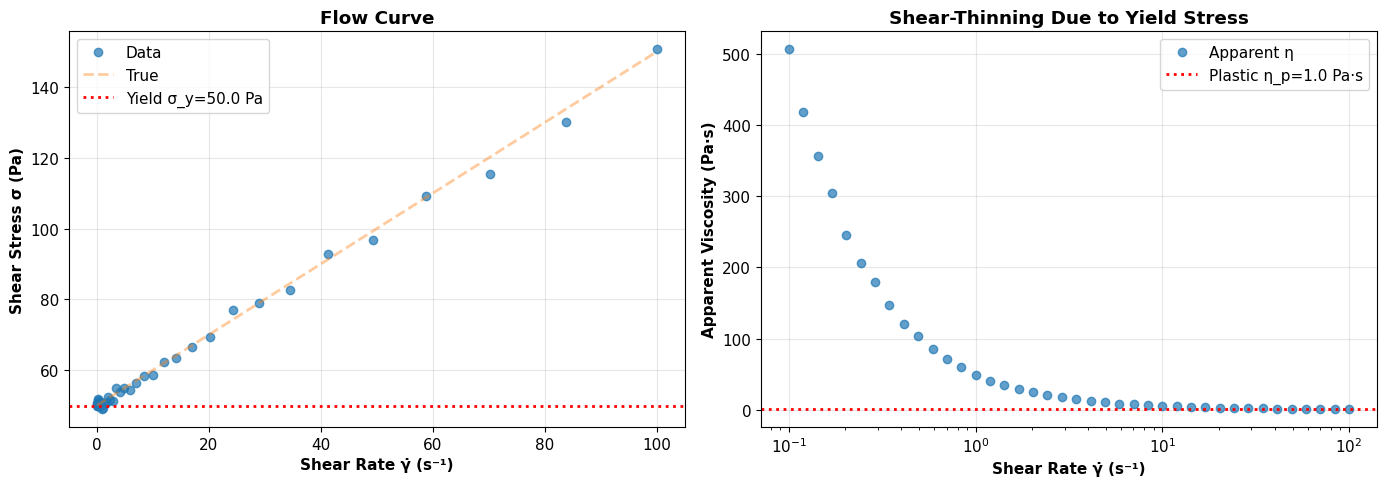

In [4]:
# Visualize flow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(gamma_dot, sigma_noisy, 'o', alpha=0.7, label='Data')
ax1.plot(gamma_dot, sigma_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.axhline(sigma_y_true, color='red', linestyle=':', linewidth=2, label=f'Yield σ_y={sigma_y_true} Pa')
ax1.set_xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
ax1.set_ylabel('Shear Stress σ (Pa)', fontweight='bold')
ax1.set_title('Flow Curve', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Viscosity
eta_apparent = sigma_noisy / gamma_dot
ax2.semilogx(gamma_dot, eta_apparent, 'o', alpha=0.7, label='Apparent η')
ax2.axhline(eta_p_true, color='red', linestyle=':', linewidth=2, label=f'Plastic η_p={eta_p_true} Pa·s')
ax2.set_xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
ax2.set_ylabel('Apparent Viscosity (Pa·s)', fontweight='bold')
ax2.set_title('Shear-Thinning Due to Yield Stress', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)


## Fitting (Linear Regression)

Bingham model is linear: σ = σ_y + η_p·γ̇, so we can use simple linear regression.

In [5]:
model = Bingham()
model.fit(gamma_dot, sigma_noisy)

sigma_y_fit = model.parameters.get_value('sigma_y')
eta_p_fit = model.parameters.get_value('eta_p')

print("="*60)
print("FITTED PARAMETERS")
print("="*60)
print(f"σ_y = {sigma_y_fit:.2f} Pa (true: {sigma_y_true:.2f})")
print(f"η_p = {eta_p_fit:.3f} Pa·s (true: {eta_p_true:.3f})")
print(f"\nErrors: σ_y {abs(sigma_y_fit-sigma_y_true)/sigma_y_true*100:.2f}%, η_p {abs(eta_p_fit-eta_p_true)/eta_p_true*100:.2f}%")
print("="*60)

FITTED PARAMETERS
σ_y = 50.08 Pa (true: 50.00)
η_p = 0.979 Pa·s (true: 1.000)

Errors: σ_y 0.16%, η_p 2.07%


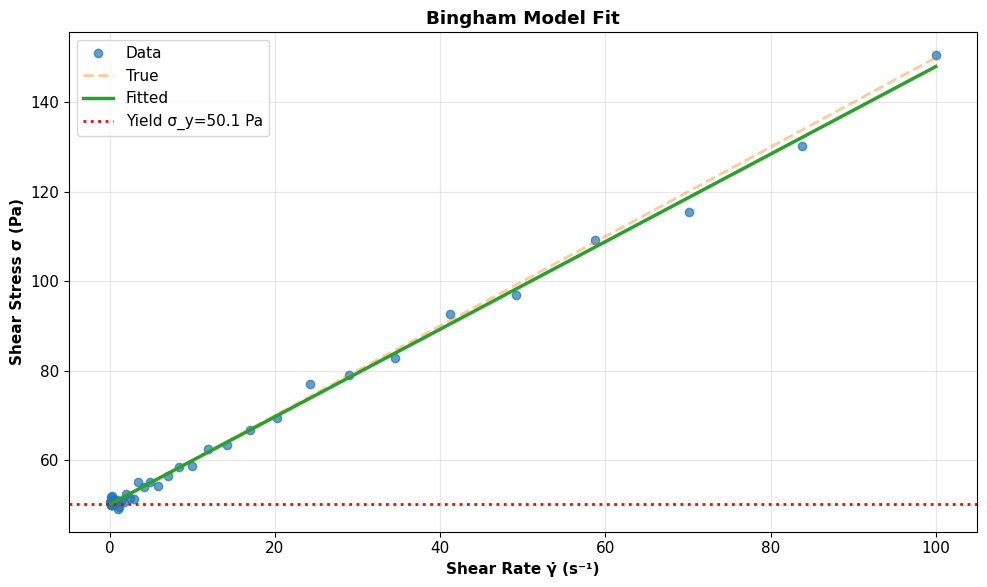

R² = 0.996998


In [6]:
# Visualize fit
sigma_pred = model.predict(gamma_dot)

fig = plt.figure(figsize=(10, 6))
plt.plot(gamma_dot, sigma_noisy, 'o', alpha=0.7, label='Data')
plt.plot(gamma_dot, sigma_true, '--', linewidth=2, alpha=0.4, label='True')
plt.plot(gamma_dot, sigma_pred, '-', linewidth=2.5, label='Fitted')
plt.axhline(sigma_y_fit, color='red', linestyle=':', linewidth=2, label=f'Yield σ_y={sigma_y_fit:.1f} Pa')
plt.xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
plt.ylabel('Shear Stress σ (Pa)', fontweight='bold')
plt.title('Bingham Model Fit', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

r2 = 1 - np.sum((sigma_noisy - sigma_pred)**2) / np.sum((sigma_noisy - np.mean(sigma_noisy))**2)
print(f"R² = {r2:.6f}")


## Bayesian Inference

Quantify yield stress uncertainty - critical for process design!

In [7]:
print("Running Bayesian inference...\n")

result = model.fit_bayesian(
    gamma_dot, sigma_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'sigma_y': sigma_y_fit,
        'eta_p': eta_p_fit
    }
)

print("Complete!")

Running Bayesian inference...



/Users/b80985/Projects/rheojax/rheojax/core/base.py:457: UserWarning: test_mode not specified. Defaulting to 'relaxation'. For correct posteriors, pass RheoData with metadata['test_mode'] or specify test_mode explicitly.
  result = super().fit_bayesian(


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<19:24,  2.57it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 77/3000 [00:00<00:14, 206.14it/s, 15 steps of size 1.72e-03. acc. prob=0.93]

warmup:   6%|▌         | 187/3000 [00:00<00:06, 451.85it/s, 31 steps of size 2.13e-01. acc. prob=0.97]

warmup:  12%|█▏        | 361/3000 [00:00<00:03, 815.53it/s, 15 steps of size 2.07e-01. acc. prob=0.97]

warmup:  16%|█▌        | 475/3000 [00:00<00:02, 894.71it/s, 15 steps of size 1.83e-01. acc. prob=0.97]

warmup:  20%|█▉        | 587/3000 [00:00<00:02, 874.39it/s, 31 steps of size 1.76e-01. acc. prob=0.98]

warmup:  23%|██▎       | 694/3000 [00:01<00:02, 925.13it/s, 7 steps of size 2.00e-01. acc. prob=0.98] 

warmup:  27%|██▋       | 798/3000 [00:01<00:02, 874.08it/s, 7 steps of size 2.26e-01. acc. prob=0.98]

warmup:  31%|███▏      | 944/3000 [00:01<00:01, 1030.00it/s, 15 steps of size 2.06e-01. acc. prob=0.98]

sample:  35%|███▌      | 1058/3000 [00:01<00:01, 1059.81it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  39%|███▉      | 1170/3000 [00:01<00:01, 1050.59it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  44%|████▎     | 1309/3000 [00:01<00:01, 1139.15it/s, 7 steps of size 2.46e-01. acc. prob=0.99] 

sample:  48%|████▊     | 1427/3000 [00:01<00:01, 1128.39it/s, 11 steps of size 2.46e-01. acc. prob=0.99]

sample:  51%|█████▏    | 1543/3000 [00:01<00:01, 1106.09it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  55%|█████▌    | 1656/3000 [00:01<00:01, 1106.17it/s, 3 steps of size 2.46e-01. acc. prob=0.99] 

sample:  59%|█████▉    | 1768/3000 [00:02<00:01, 964.08it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  63%|██████▎   | 1889/3000 [00:02<00:01, 1027.15it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  69%|██████▉   | 2068/3000 [00:02<00:00, 1234.45it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  75%|███████▌  | 2253/3000 [00:02<00:00, 1404.71it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  80%|███████▉  | 2398/3000 [00:02<00:00, 1360.31it/s, 7 steps of size 2.46e-01. acc. prob=0.99] 

sample:  85%|████████▍ | 2538/3000 [00:02<00:00, 1230.67it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  90%|████████▉ | 2687/3000 [00:02<00:00, 1298.71it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

sample:  94%|█████████▍| 2821/3000 [00:02<00:00, 1254.00it/s, 7 steps of size 2.46e-01. acc. prob=0.99] 

sample:  98%|█████████▊| 2950/3000 [00:02<00:00, 1221.16it/s, 7 steps of size 2.46e-01. acc. prob=0.99]

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1008.31it/s, 15 steps of size 2.46e-01. acc. prob=0.99]

Complete!


In [8]:
summary = result.summary
diagnostics = result.diagnostics
credible = model.get_credible_intervals(result.posterior_samples, 0.95)

print("="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nσ_y = {summary['sigma_y']['mean']:.2f} ± {summary['sigma_y']['std']:.2f} Pa")
print(f"η_p = {summary['eta_p']['mean']:.3f} ± {summary['eta_p']['std']:.3f} Pa·s")
print(f"\n95% CI σ_y: [{credible['sigma_y'][0]:.2f}, {credible['sigma_y'][1]:.2f}] Pa")
print(f"95% CI η_p: [{credible['eta_p'][0]:.3f}, {credible['eta_p'][1]:.3f}] Pa·s")
print(f"\nR-hat: σ_y={diagnostics['r_hat']['sigma_y']:.4f}, η_p={diagnostics['r_hat']['eta_p']:.4f}")
print(f"ESS: σ_y={diagnostics['ess']['sigma_y']:.0f}, η_p={diagnostics['ess']['eta_p']:.0f}")
print("="*60)

print(f"\n✓ Yield stress uncertainty: ±{summary['sigma_y']['std']/summary['sigma_y']['mean']*100:.1f}%")

POSTERIOR SUMMARY

σ_y = 49.91 ± 0.26 Pa
η_p = 0.982 ± 0.009 Pa·s

95% CI σ_y: [49.41, 50.41] Pa
95% CI η_p: [0.964, 0.999] Pa·s

R-hat: σ_y=1.0000, η_p=1.0000
ESS: σ_y=2000, η_p=2000

✓ Yield stress uncertainty: ±0.5%


## Key Takeaways

1. **Yield Stress:** Minimum stress for flow - critical for pumping/processing
2. **Linear Above Yield:** Newtonian behavior once flowing (η_p constant)
3. **Bayesian Uncertainty:** Quantifies yield stress uncertainty for safety margins

## Next Steps

- **[05-power-law-fitting.ipynb](05-power-law-fitting.ipynb)**: Shear-thinning without yield stress
- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Combined fitting

In [9]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"Rheo: {rheojax.__version__}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo: 0.6.0
